In [1]:
!pip install numpy

In [1]:
!pip install transformers
!pip install hazm
!pip install seqeval
!pip install keras-preprocessing
!pip install sentencepiece
!pip install accelerate -U
!pip install torch transformers datasets

In [2]:
import os
import gc
import ast
import time
import hazm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModelForTokenClassification
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [8]:
class NER:
    def __init__(self, model_name):
        self.normalizer = hazm.Normalizer()
        self.model_name = model_name
        self.config = AutoConfig.from_pretrained(self.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForTokenClassification.from_pretrained(self.model_name)
        self.id2label = self.config.id2label

In [9]:
model_name='HooshvareLab/bert-base-parsbert-ner-uncased'
ner_model = NER(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/651M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-ner-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def load_datasets(file_name):
    data = pd.read_csv(file_name)
    sentences, sentences_tags = data['text'].values.tolist(), data['label'].values.tolist()
    print(f'{file_name} part:\n #sentences: {len(sentences)}, #sentences_tags: {len(sentences_tags)}')
    return sentences, sentences_tags

dataset_dir = "./"
sentences_train, labels_train = load_datasets('train.csv')
sentences_test, labels_test = load_datasets('test.csv')
sentences_dev, labels_dev = load_datasets('validation.csv')

print(len(sentences_train), len(labels_train))
print(sentences_train[3])
print(labels_train[3])


train.csv part:
 #sentences: 10241, #sentences_tags: 10241
test.csv part:
 #sentences: 7681, #sentences_tags: 7681
validation.csv part:
 #sentences: 5121, #sentences_tags: 5121
10241 10241
اردبیل ـ استاندار اردبیل گفت : به مناسبت هفته دولت 0 طرح عمرانی و تولیدی در مناطق روستائی و شهری این استان به بهره‌برداری می‌رسد .
B-loc O O B-loc O O O O B-event I-event O O O O O O O O O O O O O O O O


In [9]:
data = pd.read_csv("test.csv")
data

,text,label
0,افقی : 0 ـ از عوامل دوران پهلوی و نخست‌وزیر ای...,O O O O O O O O O O B-loc O O O O O O O O O O ...
1,طاهایی گفت : 0 طرح عمرانی ، 0 طرح مدرسه‌سازی د...,B-pers O O O O O O O O O O O O O O O O O O O O...
2,وي افزود : از آن جا كه منطقه یادشده به عنوان ي...,O O O O O O O O O O O O O O O O O O O B-loc I-...
3,هیأت باستانی منطقه سمیرم همچنین موفق به کشف 0 ...,O O B-loc I-loc O O O O O O O O O O O O O
4,شهرضا ـ وزیر نیرو ، زمان بهره‌برداری از طرح تأ...,B-loc O O B-org O O O O O O O O B-loc I-loc O ...
...,...,...
7676,او مانند بسیاری دیگر بدبین بار آمد و از هر چه ...,O O O O O O O O O O O O O O O O O O B-loc O O ...
7677,می‌خواهم بچه داشته باشم ولی نه در اینجا .,O O O O O O O O O
7678,می‌دانم با رفتنم همه را از دست خواهم داد ولی ب...,O O O O O O O O O O O O O
7679,حدود هفتاد و پنج نفر در یک اتاق کوچک جمع شده ب...,O O O O O O O O O O O O O


In [8]:
labels_test

['O O O O O O O O O O B-loc O O O O O O O O O O O O O O B-loc O O O O O O O O O O O O O O O O O O O O O O O O O B-loc I-loc I-loc I-loc O O O O O O O O O O O O O O O O O B-loc O O O O O O O O O B-loc O O O B-pers O O B-loc O O O O O O O O O O O O O O O O O O B-loc O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-loc O B-loc O O O O O O B-org O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-loc O O O O O O B-pers I-pers O B-org O O O O O O O O O O O O O',
 'B-pers O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-event I-event O O O O O',
 'O O O O O O O O O O O O O O O O O O O B-loc I-loc I-loc O B-loc I-loc O O O O B-loc I-loc O O O O O O O O O O O O O O O O O O O O O',
 'O O B-loc I-loc O O O O O O O O O O O O O',
 'B-loc O O B-org O O O O O O O O B-loc I-loc O O B-loc I-loc O O O O O O',
 'O B-pers O O B-loc O O O O O O O O O O O O O O O O O O O O O O B-loc O O O O O O O O O

Check file path and read dataset then get words and their lables

In [6]:
import ast

def check_label(self, labels):
    model_labels = self.config.label2id.keys()
    dataset_labels = set()
    for label_sequence in labels:
        label_list = label_sequence.split()
        dataset_labels.update(label_list)
    print("model labels:", model_labels)
    print("dataset labels:", dataset_labels)
    if list(set(dataset_labels) - set(model_labels)):
        return False
    return True


def resolve_label(labels, label_translation_map):
    for i, sentence_labels in enumerate(labels):
        label_list = sentence_labels.split()
        label_list = [label_translation_map.get(label, label) for label in label_list]
        labels[i] = ' '.join(label_list)
    return labels

In [18]:
is_consistent = check_label(ner_model, labels_train)
print(is_consistent)

model labels: dict_keys(['B-date', 'B-event', 'B-facility', 'B-location', 'B-money', 'B-organization', 'B-percent', 'B-person', 'B-product', 'B-time', 'I-date', 'I-event', 'I-facility', 'I-location', 'I-money', 'I-organization', 'I-percent', 'I-person', 'I-product', 'I-time', 'O'])
dataset labels: {'O', 'I-event', 'B-org', 'I-loc', 'I-pro', 'I-pers', 'B-pers', 'I-org', 'B-fac', 'B-loc', 'B-pro', 'B-event', 'I-fac'}
False


In [19]:
is_consistent = check_label(ner_model, labels_dev)
print(is_consistent)

model labels: dict_keys(['B-date', 'B-event', 'B-facility', 'B-location', 'B-money', 'B-organization', 'B-percent', 'B-person', 'B-product', 'B-time', 'I-date', 'I-event', 'I-facility', 'I-location', 'I-money', 'I-organization', 'I-percent', 'I-person', 'I-product', 'I-time', 'O'])
dataset labels: {'O', 'I-event', 'I-fac', 'I-loc', 'I-pro', 'I-pers', 'B-pers', 'I-org', 'B-fac', 'B-loc', 'B-pro', 'B-event', 'B-org'}
False


In [20]:
is_consistent = check_label(ner_model, labels_test)
print(is_consistent)

model labels: dict_keys(['B-date', 'B-event', 'B-facility', 'B-location', 'B-money', 'B-organization', 'B-percent', 'B-person', 'B-product', 'B-time', 'I-date', 'I-event', 'I-facility', 'I-location', 'I-money', 'I-organization', 'I-percent', 'I-person', 'I-product', 'I-time', 'O'])
dataset labels: {'O', 'I-event', 'I-fac', 'I-loc', 'I-pro', 'I-pers', 'B-pers', 'I-org', 'B-fac', 'B-loc', 'B-pro', 'B-event', 'B-org'}
False


Translate datadet labels to model labels

In [5]:
label_translate = {
    'B-fac': 'B-facility',
    'I-fac': 'I-facility',
    'B-loc': 'B-location',
    'I-loc': 'I-location',
    'B-org': 'B-organization',
    'I-org': 'I-organization',
    'B-pro': 'B-product',
    'I-pro': 'I-product',
    'B-event': 'B-event',
    'I-event': 'I-event',
    'B-pers': 'B-person',
    'I-pers': 'I-person',
    'O': 'O'
}


In [22]:
resolved_labels_train = resolve_label(labels_train, label_translate)
is_consistent = check_label(ner_model, resolved_labels_train)
print(is_consistent)

model labels: dict_keys(['B-date', 'B-event', 'B-facility', 'B-location', 'B-money', 'B-organization', 'B-percent', 'B-person', 'B-product', 'B-time', 'I-date', 'I-event', 'I-facility', 'I-location', 'I-money', 'I-organization', 'I-percent', 'I-person', 'I-product', 'I-time', 'O'])
dataset labels: {'O', 'B-organization', 'I-event', 'I-person', 'I-facility', 'B-person', 'I-organization', 'I-product', 'I-location', 'B-location', 'B-product', 'B-facility', 'B-event'}
True


In [10]:
resolved_labels_test = resolve_label(labels_test, label_translate)
is_consistent = check_label(ner_model, resolved_labels_test)
print(is_consistent)

model labels: dict_keys(['B-date', 'B-event', 'B-facility', 'B-location', 'B-money', 'B-organization', 'B-percent', 'B-person', 'B-product', 'B-time', 'I-date', 'I-event', 'I-facility', 'I-location', 'I-money', 'I-organization', 'I-percent', 'I-person', 'I-product', 'I-time', 'O'])
dataset labels: {'I-facility', 'I-event', 'I-person', 'I-organization', 'B-facility', 'O', 'B-location', 'B-product', 'I-product', 'B-organization', 'B-person', 'I-location', 'B-event'}
True


In [24]:
resolved_labels_dev = resolve_label(labels_dev, label_translate)
is_consistent = check_label(ner_model, resolved_labels_dev)
print(is_consistent)

model labels: dict_keys(['B-date', 'B-event', 'B-facility', 'B-location', 'B-money', 'B-organization', 'B-percent', 'B-person', 'B-product', 'B-time', 'I-date', 'I-event', 'I-facility', 'I-location', 'I-money', 'I-organization', 'I-percent', 'I-person', 'I-product', 'I-time', 'O'])
dataset labels: {'O', 'B-organization', 'I-event', 'I-person', 'I-facility', 'B-person', 'I-organization', 'B-facility', 'I-location', 'B-location', 'B-product', 'I-product', 'B-event'}
True


For this part I am gonna use 2 prediction functions one by the pipeline (without 'O' label) and the other with the 'O' labels.

In [15]:
from transformers import pipeline

def predict(input_text):
    nlp = pipeline("ner", model="HooshvareLab/bert-base-parsbert-ner-uncased")
    output_predictions = []
    for sequence in input_text:
        result = nlp(sequence)
        output_predictions.append(result)
    return output_predictions


In [16]:
text = [
"علی اکبری در روز شنبه به دیدن مادرش مریم حسنی رفت و بعد به بیمارستان ارتش سر زد"
]

In [17]:
output = predict(text)
print(output)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-ner-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[[{'entity': 'B-person', 'score': 0.9998951, 'index': 1, 'word': 'علی', 'start': 0, 'end': 3}, {'entity': 'I-person', 'score': 0.9999027, 'index': 2, 'word': 'اکبری', 'start': 4, 'end': 9}, {'entity': 'B-person', 'score': 0.9998709, 'index': 9, 'word': 'مریم', 'start': 36, 'end': 40}, {'entity': 'I-person', 'score': 0.9996691, 'index': 10, 'word': 'حسنی', 'start': 41, 'end': 45}, {'entity': 'B-facility', 'score': 0.9561743, 'index': 15, 'word': 'بیمارستان', 'start': 59, 'end': 68}, {'entity': 'I-facility', 'score': 0.9976502, 'index': 16, 'word': 'ارتش', 'start': 69, 'end': 73}]]


In [37]:
def predict(self, input_text, device, max_length):
        pt_batch = self.tokenizer(
            [self.normalizer.normalize(sequence) for sequence in input_text],
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        gc.collect()
        torch.cuda.empty_cache()
        if device.type != 'cpu':
            self.model.cuda()
        pt_batch = pt_batch.to(device)
        pt_outputs = self.model(**pt_batch)
        pt_predictions = torch.argmax(pt_outputs.logits, dim=-1)
        pt_predictions = pt_predictions.cpu().detach().numpy().tolist()
        output_predictions = []
        for i, sequence in enumerate(input_text):
            tokens = self.tokenizer.tokenize(self.tokenizer.decode(self.tokenizer.encode(sequence)))
            predictions = [(token, self.id2label[prediction]) for token, prediction in
                           zip(tokens, pt_predictions[i])]
            output_predictions.append(predictions)
        return output_predictions

In [23]:
text = [
"علی اکبری در روز شنبه به دیدن مادرش مریم حسنی رفت و بعد به بیمارستان ارتش سر زد"
]

In [24]:
output = predict(ner_model, text, device, ner_model.config.max_position_embeddings)
print(output)

[[('[CLS]', 'O'), ('علی', 'B-person'), ('اکبری', 'I-person'), ('در', 'O'), ('روز', 'O'), ('شنبه', 'O'), ('به', 'O'), ('دیدن', 'O'), ('مادرش', 'O'), ('مریم', 'B-person'), ('حسنی', 'I-person'), ('رفت', 'O'), ('و', 'O'), ('بعد', 'O'), ('به', 'O'), ('بیمارستان', 'B-facility'), ('ارتش', 'I-facility'), ('سر', 'O'), ('زد', 'O'), ('[SEP]', 'O')]]


In [23]:
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.8 MB/s eta 0:00:00


In [20]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset

model_name = "HooshvareLab/bert-base-parsbert-ner-uncased"

ner_model = NER(model_name)

max_length = 128

train_encodings = ner_model.tokenizer(sentences_train, truncation=True, padding='max_length', max_length=max_length)
val_encodings = ner_model.tokenizer(sentences_dev, truncation=True, padding='max_length', max_length=max_length)

train_labels = [[ner_model.config.label2id.get(label, -100) for label in sentence_labels.split()[:max_length]] + [-100]*(max_length - len(sentence_labels.split())) for sentence_labels in resolved_labels_train]
val_labels = [[ner_model.config.label2id.get(label, -100) for label in sentence_labels.split()[:max_length]] + [-100]*(max_length - len(sentence_labels.split())) for sentence_labels in resolved_labels_dev]

train_encodings["labels"] = train_labels
val_encodings["labels"] = val_labels

train_dataset = Dataset.from_dict(train_encodings)
val_dataset = Dataset.from_dict(val_encodings)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=ner_model.model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-ner-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss
500,0.288100
1000,0.058300
1500,0.037300


TrainOutput(global_step=1923, training_loss=0.10466873329626789, metrics={'train_runtime': 782.6978, 'train_samples_per_second': 39.253, 'train_steps_per_second': 2.457, 'total_flos': 2007299814702336.0, 'train_loss': 0.10466873329626789, 'epoch': 3.0})

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
save_directory = "/content/drive/MyDrive/NER"

ner_model.model.save_pretrained(save_directory)
ner_model.tokenizer.save_pretrained(save_directory)


('/content/drive/MyDrive/NER/tokenizer_config.json',
 '/content/drive/MyDrive/NER/special_tokens_map.json',
 '/content/drive/MyDrive/NER/vocab.txt',
 '/content/drive/MyDrive/NER/added_tokens.json',
 '/content/drive/MyDrive/NER/tokenizer.json')

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

test_sentences = sentences_test
test_labels = resolved_labels_test

num_sentences = len(test_sentences)
num_subset_sentences = int(num_sentences * 0.1)

subset_sentences = test_sentences[:num_subset_sentences]
subset_labels = test_labels[:num_subset_sentences]



In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

test_sentences = sentences_test
test_labels = labels_test

num_sentences = len(test_sentences)
num_subset_sentences = int(num_sentences * 0.1)

subset_sentences = test_sentences[:num_subset_sentences]
subset_labels = test_labels[:num_subset_sentences]

output_predictions = []

for sentence in tqdm(subset_sentences, desc="Predicting"):
    prediction = predict([sentence])
    output_predictions.append(prediction)


Predicting:   0%|          | 0/768 [00:00<?, ?it/s]Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-ner-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Predicting:   0%|          | 1/768 [00:05<1:11:01,  5.56s/it]Some weights of the model checkpoint at HooshvareLab/bert-bas

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

test_sentences = sentences_test
test_labels = labels_test

num_sentences = len(test_sentences)
num_subset_sentences = int(num_sentences * 0.1)

subset_sentences = test_sentences[:num_subset_sentences]
subset_labels = test_labels[:num_subset_sentences]

output_predictions_with_O = []

for sentence in tqdm(subset_sentences, desc="Predicting"):
    prediction = predict(ner_model,[sentence],device, ner_model.config.max_position_embeddings)
    output_predictions_with_O.append(prediction)


Predicting: 100%|██████████| 768/768 [06:08<00:00,  2.09it/s]


In [39]:
output_predictions_with_O[0]

[[('[CLS]', 'O'),
  ('افقی', 'O'),
  (':', 'O'),
  ('[UNK]', 'O'),
  ('[UNK]', 'O'),
  ('از', 'O'),
  ('عوامل', 'O'),
  ('دوران', 'O'),
  ('پهلوی', 'O'),
  ('و', 'B-location'),
  ('نخستوزیر', 'O'),
  ('ایران', 'O'),
  ('در', 'O'),
  ('سالهای', 'O'),
  ('ابتدايی', 'O'),
  ('دهه', 'O'),
  ('چهل', 'O'),
  ('خورشیدی', 'O'),
  ('[UNK]', 'O'),
  ('جلد', 'O'),
  ('سوم', 'O'),
  ('یادداشتهای', 'O'),
  ('##ش', 'O'),
  ('هم', 'O'),
  ('چندی', 'B-location'),
  ('پیش', 'O'),
  ('در', 'O'),
  ('تهران', 'O'),
  ('منتشر', 'O'),
  ('شد', 'O'),
  ('[UNK]', 'O'),
  ('[UNK]', 'O'),
  ('پرستاری', 'O'),
  ('از', 'O'),
  ('ناخوش', 'O'),
  ('##احوال', 'O'),
  ('[UNK]', 'O'),
  ('پوشاک', 'O'),
  ('و', 'O'),
  ('جامه', 'O'),
  ('[UNK]', 'O'),
  ('فانتزی', 'O'),
  ('و', 'O'),
  ('شیک', 'O'),
  ('[UNK]', 'B-location'),
  ('[UNK]', 'I-location'),
  ('در', 'O'),
  ('حال', 'B-location'),
  ('وزیدن', 'I-location'),
  ('[UNK]', 'O'),
  ('اطلاعیه', 'O'),
  ('[UNK]', 'O'),
  ('پایتخت', 'O'),
  ('جمهوری', 'O'),
  ('استو

In [42]:
from google.colab import drive
import json


file_path = "/content/drive/My Drive/NER/output_predictions_with_O.json"

def convert(o):
    if isinstance(o, np.float32):
        return float(o)
    raise TypeError

output_predictions_json = json.dumps(output_predictions_with_O, default=convert)

with open(file_path, 'w') as f:
    f.write(output_predictions_json)


In [13]:
import json
file_path = "/content/drive/My Drive/NER/output_predictions_with_O.json"

with open(file_path, 'r') as f:
    output_predictions_with_O = json.load(f)


Now here we evaulate our data

In [35]:
subset_labels[0]

'O O O O O O O O O O B-location O O O O O O O O O O O O O O B-location O O O O O O O O O O O O O O O O O O O O O O O O O B-location I-location I-location I-location O O O O O O O O O O O O O O O O O B-location O O O O O O O O O B-location O O O B-person O O B-location O O O O O O O O O O O O O O O O O O B-location O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-location O B-location O O O O O O B-organization O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-location O O O O O O B-person I-person O B-organization O O O O O O O O O O O O O'

In [36]:
output_predictions[0]

[[{'entity': 'B-location',
   'score': 0.9994905,
   'index': 11,
   'word': 'ایران',
   'start': 44,
   'end': 49},
  {'entity': 'I-date',
   'score': 0.73302937,
   'index': 16,
   'word': 'چهل',
   'start': 72,
   'end': 75},
  {'entity': 'I-date',
   'score': 0.6518448,
   'index': 17,
   'word': 'خورشیدی',
   'start': 76,
   'end': 83},
  {'entity': 'B-location',
   'score': 0.99982774,
   'index': 27,
   'word': 'تهران',
   'start': 122,
   'end': 127},
  {'entity': 'B-location',
   'score': 0.9975076,
   'index': 54,
   'word': 'استونی',
   'start': 237,
   'end': 243},
  {'entity': 'I-location',
   'score': 0.68535507,
   'index': 56,
   'word': 'حوضه',
   'start': 247,
   'end': 251},
  {'entity': 'I-location',
   'score': 0.9627829,
   'index': 57,
   'word': 'بالتیک',
   'start': 252,
   'end': 258},
  {'entity': 'B-location',
   'score': 0.9997322,
   'index': 75,
   'word': 'ایران',
   'start': 322,
   'end': 327},
  {'entity': 'B-location',
   'score': 0.99873203,
   'ind

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
from itertools import chain

def evaluate_results(labels, output_predictions):
    true_bin = []
    pred_bin = []

    for true_label_list, pred_list in zip(labels, output_predictions):
        true_labels = [label for label in true_label_list.split() if label != 'O']
        predictions = [item[1] for sublist in output_predictions for item in sublist if item[1] != 'O']

        if len(predictions) == 0 or len(true_labels) == 0:
            continue

        true_counts = Counter(true_labels)
        pred_counts = Counter(predictions)

        for label in true_counts:
            true_bin.extend([1]*true_counts[label])
            pred_bin.extend([1]*min(true_counts[label], pred_counts[label]))
            pred_bin.extend([0]*max(0, true_counts[label]-pred_counts[label]))

    print("Test Accuracy: {}".format(accuracy_score(true_bin, pred_bin)))
    print("Test Precision: {}".format(precision_score(true_bin, pred_bin)))
    print("Test Recall: {}".format(recall_score(true_bin, pred_bin)))
    print("Test F1-Score: {}".format(f1_score(true_bin, pred_bin)))

evaluate_results([subset_labels[0]], output_predictions_with_O[0])


Test Accuracy: 0.8333333333333334
Test Precision: 1.0
Test Recall: 0.8333333333333334
Test F1-Score: 0.9090909090909091


Test Accuracy: 0.9433962264150944
Test Precision: 0.7983091787439612
Test Recall: 0.7983091787439612
Test F1-Score: 0.7983091787439612


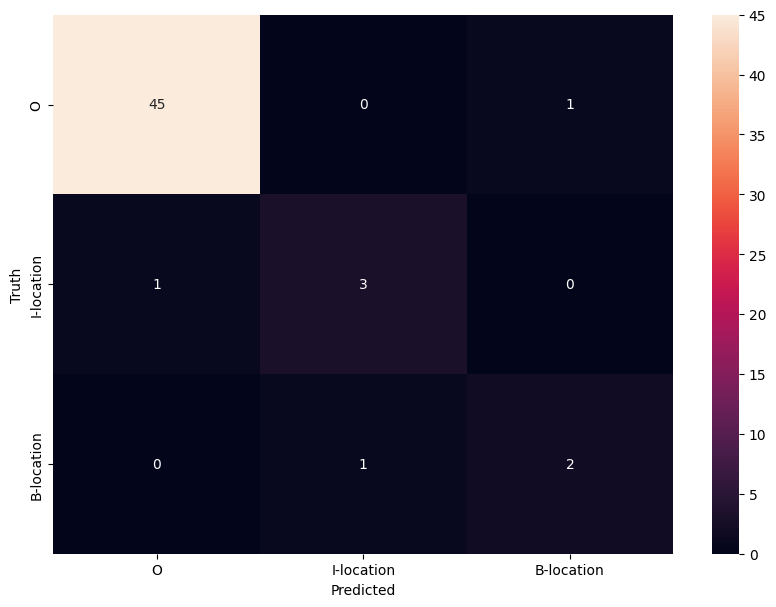

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_results(labels, output_predictions):
    true_labels_list = []
    pred_labels_list = []

    for true_label_list, pred_list in zip(labels, output_predictions):
        true_labels = [label for label in true_label_list.split()]
        predictions = [item[1] for item in pred_list]

        true_labels_list.extend(true_labels)
        pred_labels_list.extend(predictions)

    print("Test Accuracy: {}".format(accuracy_score(true_labels_list, pred_labels_list)))
    print("Test Precision: {}".format(precision_score(true_labels_list, pred_labels_list, average='macro')))
    print("Test Recall: {}".format(recall_score(true_labels_list, pred_labels_list, average='macro')))
    print("Test F1-Score: {}".format(f1_score(true_labels_list, pred_labels_list, average='macro')))

    # Calculate confusion matrix
    labels_unique = list(set(true_labels_list + pred_labels_list))
    cm = confusion_matrix(true_labels_list, pred_labels_list, labels=labels_unique)

    # Plot confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_unique, yticklabels=labels_unique)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

evaluate_results([subset_labels[2]], output_predictions_with_O[2])


Without Accounting the 'O'

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
from itertools import chain
import numpy as np

def evaluate_results(labels, output_predictions):
    true_bin = []
    pred_bin = []

    true_labels = [label for label in labels.split() if label != 'O']
    predictions = [item[1] for sublist in output_predictions for item in sublist if item[1] != 'O']
    if len(predictions) == 0 or len(true_labels) == 0:
        return None

    true_counts = Counter(true_labels)
    pred_counts = Counter(predictions)

    for label in true_counts:
        true_bin.extend([1]*true_counts[label])
        pred_bin.extend([1]*min(true_counts[label], pred_counts[label]))
        pred_bin.extend([0]*max(0, true_counts[label]-pred_counts[label]))

    return accuracy_score(true_bin, pred_bin), precision_score(true_bin, pred_bin), recall_score(true_bin, pred_bin), f1_score(true_bin, pred_bin, average='macro'), f1_score(true_bin, pred_bin, average='micro')

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_macro_scores = []
f1_micro_scores = []

for labels, predictions in zip(subset_labels, output_predictions_with_O):
    scores = evaluate_results(labels, predictions)
    if scores is not None:
        accuracy, precision, recall, f1_macro, f1_micro = scores
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_macro_scores.append(f1_macro)
        f1_micro_scores.append(f1_micro)

print("Mean Test Accuracy: {}".format(np.mean(accuracy_scores)))
print("Mean Test Precision: {}".format(np.mean(precision_scores)))
print("Mean Test Recall: {}".format(np.mean(recall_scores)))
print("Mean Test F1-Score (Macro): {}".format(np.mean(f1_macro_scores)))
print("Mean Test F1-Score (Micro): {}".format(np.mean(f1_micro_scores)))


Mean Test Accuracy: 0.9737285471164965
Mean Test Precision: 1.0
Mean Test Recall: 0.9737285471164965
Mean Test F1-Score (Macro): 0.9299416489623261
Mean Test F1-Score (Micro): 0.9737285471164965


Accounting the 'O'

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
from itertools import chain
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def evaluate_results(labels, output_predictions):
    true_labels_list = []
    pred_labels_list = []

    for true_label_list, pred_list in zip(labels, output_predictions):
        true_labels = [label for label in true_label_list.split()]
        predictions = [item[1] for item in pred_list]

        true_labels_list.extend(true_labels)
        pred_labels_list.extend(predictions)

    return accuracy_score(true_labels_list, pred_labels_list), precision_score(true_labels_list, pred_labels_list, average='macro'), recall_score(true_labels_list, pred_labels_list, average='macro'), f1_score(true_labels_list, pred_labels_list, average='macro'), f1_score(true_labels_list, pred_labels_list, average='micro')

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_macro_scores = []
f1_micro_scores = []

for labels, predictions in zip(subset_labels, output_predictions_with_O):
    scores = evaluate_results(labels, predictions)
    if scores is not None:
        accuracy, precision, recall, f1_macro, f1_micro = scores
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_macro_scores.append(f1_macro)
        f1_micro_scores.append(f1_micro)

print("Mean Test Accuracy: {}".format(np.mean(accuracy_scores)))
print("Mean Test Precision: {}".format(np.mean(precision_scores)))
print("Mean Test Recall: {}".format(np.mean(recall_scores)))
print("Mean Test F1-Score (Macro): {}".format(np.mean(f1_macro_scores)))
print("Mean Test F1-Score (Micro): {}".format(np.mean(f1_micro_scores)))


Mean Test Accuracy: 0.9089793662485398
Mean Test Precision: 0.5677042467081529
Mean Test Recall: 0.546468283492587
Mean Test F1-Score (Macro): 0.5558152680552105
Mean Test F1-Score (Micro): 0.9089793662485398
